In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pip install tensorflow_datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.5/126.5 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 8.4 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 6.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.9/230.9 kB 5.7 MB/s eta 0:00:0000:01
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21483 sha256=78c5477c8cbb0e5f2ea7ea25e0e2f445e7df36779014a7f7211e60a3bd1d3819
  Stored in directory: /Users/mikeredshaw/Library/Caches/pip/wheels/90/74/b1/9b54c896b8d9409e9268329d4d45ede8a8040abe91c8879932
Successfully built promise
  Attempting uninstall: protobuf
    Found existing installation: protobu

In [3]:
import tensorflow_datasets as tfds

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
(train, test) = tfds.load('mnist',
                                split = ['train','test'])

2023-11-15 05:42:31.285882: W tensorflow/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


Dl Completed...: 100%|██████████| 5/5 [00:03<00:00,  1.30 file/s]

Dataset mnist downloaded and prepared to /Users/mikeredshaw/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [5]:
train

<_PrefetchDataset element_spec={'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

In [6]:
test

<_PrefetchDataset element_spec={'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

def load_dataset(train_size, test_size):
    train, test = tf.keras.datasets.mnist.load_data()

    # take a sample
    train_idx = np.random.randint(low=0, high=train[0].shape[0], size=train_size)
    test_idx = np.random.randint(low=0, high=test[0].shape[0], size=test_size)
    X_train = train[0][train_idx].reshape(-1,28*28)
    y_train = train[1][train_idx].reshape(-1,1)
    X_test = test[0][test_idx].reshape(-1,28*28)
    y_test = test[1][test_idx].reshape(-1,1)

    scale = StandardScaler()
    X_train = scale.fit_transform(X_train)
    X_test = scale.transform(X_test)

    OH = OneHotEncoder(categories='auto', sparse=False)
    y_train = OH.fit_transform(y_train)
    y_test = OH.transform(y_test)

    print('X_train:',X_train.shape)
    print('y_train:',y_train.shape)
    print('X_test:',X_test.shape)
    print('y_test:',y_test.shape)
    print('Min:', X_train.min())
    print('Max:', X_train.max())

    return X_train, X_test, y_train, y_test


In [8]:
X_train, X_test, y_train, y_test = load_dataset(60000,10000)

X_train: (60000, 784)
y_train: (60000, 10)
X_test: (10000, 784)
y_test: (10000, 10)
Min: -1.2692813895813595
Max: 244.94693302866423


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### Optimizing at the Initialization Stage

In [9]:
from tensorflow.keras import layers

In [10]:
def simple_model(initializer, activation='relu'):
    return tf.keras.Sequential([layers.Dense(32, activation, input_shape=(784,), kernel_initializer=initializer),
                                layers.Dense(32, activation, kernel_initializer=initializer),
                                layers.Dense(32, activation, kernel_initializer=initializer),
                                layers.Dense(32, activation, kernel_initializer=initializer),
                                layers.Dense(10, activation = 'softmax', kernel_initializer=tf.keras.initializers.glorot_normal())
    ])

In [11]:
init = tf.initializers.zeros()
activate = 'relu'
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
model_zeros = simple_model(init, activate)
model_zeros.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model_zeros.fit(X_train, y_train, epochs=10, batch_size=3200, validation_data=(X_test, y_test))

Epoch 1/10
19/19 [==============================] - 0s 8ms/step - loss: 2.3026 - accuracy: 0.1128 - val_loss: 2.3025 - val_accuracy: 0.1108
Epoch 2/10
19/19 [==============================] - 0s 5ms/step - loss: 2.3025 - accuracy: 0.1134 - val_loss: 2.3025 - val_accuracy: 0.1108
Epoch 3/10
19/19 [==============================] - 0s 5ms/step - loss: 2.3024 - accuracy: 0.1134 - val_loss: 2.3024 - val_accuracy: 0.1108
Epoch 4/10
19/19 [==============================] - 0s 5ms/step - loss: 2.3024 - accuracy: 0.1134 - val_loss: 2.3024 - val_accuracy: 0.1108
Epoch 5/10
19/19 [==============================] - 0s 5ms/step - loss: 2.3023 - accuracy: 0.1134 - val_loss: 2.3023 - val_accuracy: 0.1108
Epoch 6/10
19/19 [==============================] - 0s 5ms/step - loss: 2.3023 - accuracy: 0.1134 - val_loss: 2.3023 - val_accuracy: 0.1108
Epoch 7/10
19/19 [==============================] - 0s 5ms/step - loss: 2.3022 - accuracy: 0.1134 - val_loss: 2.3023 - val_accuracy: 0.1108
Epoch 8/10
19/19 [==

In [12]:
init = tf.initializers.random_normal()
activate = 'relu'
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
model_normal = simple_model(init, activate)
model_normal.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model_normal.fit(X_train, y_train, epochs=10, batch_size=3200, validation_data=(X_test, y_test))

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


19/19 [==============================] - 0s 9ms/step - loss: 2.3024 - accuracy: 0.0985 - val_loss: 2.3020 - val_accuracy: 0.1028
Epoch 2/10
19/19 [==============================] - 0s 5ms/step - loss: 2.3019 - accuracy: 0.1195 - val_loss: 2.3016 - val_accuracy: 0.1365
Epoch 3/10
19/19 [==============================] - 0s 5ms/step - loss: 2.3015 - accuracy: 0.1621 - val_loss: 2.3012 - val_accuracy: 0.1776
Epoch 4/10
19/19 [==============================] - 0s 5ms/step - loss: 2.3012 - accuracy: 0.1840 - val_loss: 2.3008 - val_accuracy: 0.1935
Epoch 5/10
19/19 [==============================] - 0s 5ms/step - loss: 2.3008 - accuracy: 0.1905 - val_loss: 2.3005 - val_accuracy: 0.1928
Epoch 6/10
19/19 [==============================] - 0s 5ms/step - loss: 2.3004 - accuracy: 0.1879 - val_loss: 2.3002 - val_accuracy: 0.1866
Epoch 7/10
19/19 [==============================] - 0s 5ms/step - loss: 2.3001 - accuracy: 0.1813 - val_loss: 2.2998 - val_accuracy: 0.1857
Epoch 8/10
19/19 [=============

In [13]:
init = tf.initializers.glorot_uniform()
activate = 'relu'
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
model_glorotu = simple_model(init, activate)
model_glorotu.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model_glorotu.fit(X_train, y_train, epochs=10, batch_size=3200, validation_data=(X_test, y_test))

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


19/19 [==============================] - 0s 8ms/step - loss: 2.3393 - accuracy: 0.0927 - val_loss: 2.3031 - val_accuracy: 0.0960
Epoch 2/10
19/19 [==============================] - 0s 6ms/step - loss: 2.2857 - accuracy: 0.1097 - val_loss: 2.2579 - val_accuracy: 0.1189
Epoch 3/10
19/19 [==============================] - 0s 6ms/step - loss: 2.2428 - accuracy: 0.1331 - val_loss: 2.2181 - val_accuracy: 0.1467
Epoch 4/10
19/19 [==============================] - 0s 5ms/step - loss: 2.2028 - accuracy: 0.1629 - val_loss: 2.1781 - val_accuracy: 0.1820
Epoch 5/10
19/19 [==============================] - 0s 5ms/step - loss: 2.1618 - accuracy: 0.2010 - val_loss: 2.1356 - val_accuracy: 0.2216
Epoch 6/10
19/19 [==============================] - 0s 5ms/step - loss: 2.1174 - accuracy: 0.2452 - val_loss: 2.0885 - val_accuracy: 0.2678
Epoch 7/10
19/19 [==============================] - 0s 5ms/step - loss: 2.0682 - accuracy: 0.2935 - val_loss: 2.0358 - val_accuracy: 0.3195
Epoch 8/10
19/19 [=============

In [14]:
init = tf.initializers.he_uniform()
activate = 'relu'
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
model_heu = simple_model(init, activate)
model_heu.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model_heu.fit(X_train, y_train, epochs=10, batch_size=3200, validation_data=(X_test, y_test))

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer HeUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


19/19 [==============================] - 0s 8ms/step - loss: 2.4323 - accuracy: 0.1203 - val_loss: 2.3052 - val_accuracy: 0.1497
Epoch 2/10
19/19 [==============================] - 0s 4ms/step - loss: 2.2453 - accuracy: 0.1811 - val_loss: 2.1739 - val_accuracy: 0.2189
Epoch 3/10
19/19 [==============================] - 0s 4ms/step - loss: 2.1260 - accuracy: 0.2492 - val_loss: 2.0606 - val_accuracy: 0.2818
Epoch 4/10
19/19 [==============================] - 0s 5ms/step - loss: 2.0125 - accuracy: 0.3144 - val_loss: 1.9448 - val_accuracy: 0.3438
Epoch 5/10
19/19 [==============================] - 0s 5ms/step - loss: 1.8954 - accuracy: 0.3768 - val_loss: 1.8256 - val_accuracy: 0.4068
Epoch 6/10
19/19 [==============================] - 0s 5ms/step - loss: 1.7758 - accuracy: 0.4331 - val_loss: 1.7056 - val_accuracy: 0.4603
Epoch 7/10
19/19 [==============================] - 0s 5ms/step - loss: 1.6552 - accuracy: 0.4810 - val_loss: 1.5850 - val_accuracy: 0.5118
Epoch 8/10
19/19 [=============

Text(0, 0.5, 'Validation Accuracy')

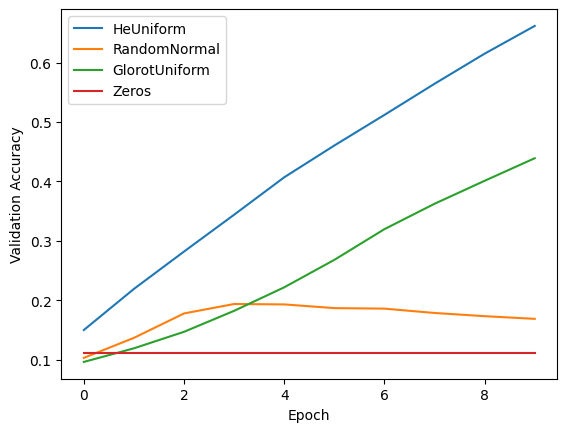

In [15]:
for i in [model_heu, model_normal, model_glorotu, model_zeros]:
    plt.plot(i.history.history['val_accuracy'], label=i.get_config()['layers'][1]['config']['kernel_initializer']['class_name'])

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')

In [16]:
def simple_model_bn(initializer = 'he_uniform', activation='relu'):
    return tf.keras.Sequential([layers.Dense(32, activation, input_shape=(784,), kernel_initializer=initializer),
                                layers.BatchNormalization(trainable=True, scale=True, center=True),
                                layers.Dense(32, activation, kernel_initializer=initializer),
                                layers.BatchNormalization(trainable=True, scale=True, center=True),
                                layers.Dense(32, activation, kernel_initializer=initializer),
                                layers.BatchNormalization(trainable=True, scale=True, center=True),
                                layers.Dense(32, activation, kernel_initializer=initializer),
                                layers.BatchNormalization(trainable=True, scale=True, center=True),
                                layers.Dense(10, activation = 'softmax', kernel_initializer=tf.keras.initializers.glorot_normal())



    ])

In [17]:
simple_model_bn().summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 32)                25120     
                                                                 
 batch_normalization (Batch  (None, 32)                128       
 Normalization)                                                  
                                                                 
 dense_21 (Dense)            (None, 32)                1056      
                                                                 
 batch_normalization_1 (Bat  (None, 32)                128       
 chNormalization)                                                
                                                                 
 dense_22 (Dense)            (None, 32)                1056      
                                                                 
 batch_normalization_2 (Bat  (None, 32)               

In [18]:
init = tf.keras.initializers.random_normal()
activate = 'relu'

optimizer = tf.keras.optimizers.SGD(0.01)
model_bn = simple_model_bn(init, activate)
model_bn.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model_bn.fit(X_train, y_train, epochs=10, batch_size=3200, validation_data = (X_test, y_test))

Epoch 1/10
19/19 [==============================] - 1s 13ms/step - loss: 2.0387 - accuracy: 0.3421 - val_loss: 2.2935 - val_accuracy: 0.1603
Epoch 2/10
19/19 [==============================] - 0s 8ms/step - loss: 1.3262 - accuracy: 0.6026 - val_loss: 2.2797 - val_accuracy: 0.1201
Epoch 3/10
19/19 [==============================] - 0s 8ms/step - loss: 1.0210 - accuracy: 0.7038 - val_loss: 2.2602 - val_accuracy: 0.1186
Epoch 4/10
19/19 [==============================] - 0s 7ms/step - loss: 0.8454 - accuracy: 0.7585 - val_loss: 2.2340 - val_accuracy: 0.1401
Epoch 5/10
19/19 [==============================] - 0s 7ms/step - loss: 0.7325 - accuracy: 0.7922 - val_loss: 2.1994 - val_accuracy: 0.1720
Epoch 6/10
19/19 [==============================] - 0s 8ms/step - loss: 0.6530 - accuracy: 0.8161 - val_loss: 2.1551 - val_accuracy: 0.2523
Epoch 7/10
19/19 [==============================] - 0s 8ms/step - loss: 0.5963 - accuracy: 0.8316 - val_loss: 2.0997 - val_accuracy: 0.4080
Epoch 8/10
19/19 [=

In [19]:
init = tf.keras.initializers.he_uniform()
activate = 'relu'

optimizer = tf.keras.optimizers.SGD(0.01)
model_bn = simple_model_bn(init, activate)
model_bn.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model_bn.fit(X_train, y_train, epochs=10, batch_size=3200, validation_data = (X_test, y_test))

Epoch 1/10
19/19 [==============================] - 1s 13ms/step - loss: 2.4790 - accuracy: 0.1744 - val_loss: 2.3704 - val_accuracy: 0.1549
Epoch 2/10
19/19 [==============================] - 0s 8ms/step - loss: 1.9752 - accuracy: 0.3530 - val_loss: 2.1558 - val_accuracy: 0.2665
Epoch 3/10
19/19 [==============================] - 0s 9ms/step - loss: 1.6780 - accuracy: 0.4836 - val_loss: 1.9464 - val_accuracy: 0.3626
Epoch 4/10
19/19 [==============================] - 0s 8ms/step - loss: 1.4849 - accuracy: 0.5584 - val_loss: 1.7404 - val_accuracy: 0.4697
Epoch 5/10
19/19 [==============================] - 0s 7ms/step - loss: 1.3411 - accuracy: 0.6100 - val_loss: 1.5552 - val_accuracy: 0.5536
Epoch 6/10
19/19 [==============================] - 0s 8ms/step - loss: 1.2272 - accuracy: 0.6483 - val_loss: 1.3952 - val_accuracy: 0.6196
Epoch 7/10
19/19 [==============================] - 0s 8ms/step - loss: 1.1331 - accuracy: 0.6822 - val_loss: 1.2601 - val_accuracy: 0.6647
Epoch 8/10
19/19 [=

In [20]:
init = tf.keras.initializers.random_uniform()
activate = 'relu'

optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.01)
model_bn_ad = simple_model_bn(init, activate)
model_bn_ad.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model_bn_ad.fit(X_train, y_train, epochs=10, batch_size=3200, validation_data = (X_test, y_test))

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


19/19 [==============================] - 1s 11ms/step - loss: 1.0822 - accuracy: 0.6692 - val_loss: 2.2980 - val_accuracy: 0.1988
Epoch 2/10
19/19 [==============================] - 0s 8ms/step - loss: 0.4817 - accuracy: 0.8709 - val_loss: 2.2921 - val_accuracy: 0.1931
Epoch 3/10
19/19 [==============================] - 0s 9ms/step - loss: 0.3685 - accuracy: 0.9032 - val_loss: 2.2843 - val_accuracy: 0.2512
Epoch 4/10
19/19 [==============================] - 0s 9ms/step - loss: 0.3134 - accuracy: 0.9177 - val_loss: 2.2747 - val_accuracy: 0.2924
Epoch 5/10
19/19 [==============================] - 0s 8ms/step - loss: 0.2763 - accuracy: 0.9279 - val_loss: 2.2623 - val_accuracy: 0.2965
Epoch 6/10
19/19 [==============================] - 0s 9ms/step - loss: 0.2495 - accuracy: 0.9344 - val_loss: 2.2455 - val_accuracy: 0.3402
Epoch 7/10
19/19 [==============================] - 0s 9ms/step - loss: 0.2284 - accuracy: 0.9403 - val_loss: 2.2240 - val_accuracy: 0.3835
Epoch 8/10
19/19 [============

In [21]:
init = tf.keras.initializers.random_uniform()
activate = 'relu'

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model_bn_adam = simple_model_bn(init, activate)
model_bn_adam.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model_bn_adam.fit(X_train, y_train, epochs=10, batch_size=3200, validation_data = (X_test, y_test))

Epoch 1/10
19/19 [==============================] - 1s 13ms/step - loss: 0.8020 - accuracy: 0.7553 - val_loss: 2.0844 - val_accuracy: 0.3125
Epoch 2/10
19/19 [==============================] - 0s 8ms/step - loss: 0.2589 - accuracy: 0.9229 - val_loss: 1.8962 - val_accuracy: 0.3452
Epoch 3/10
19/19 [==============================] - 0s 8ms/step - loss: 0.1772 - accuracy: 0.9481 - val_loss: 1.7068 - val_accuracy: 0.4563
Epoch 4/10
19/19 [==============================] - 0s 8ms/step - loss: 0.1331 - accuracy: 0.9607 - val_loss: 1.5546 - val_accuracy: 0.5590
Epoch 5/10
19/19 [==============================] - 0s 8ms/step - loss: 0.1051 - accuracy: 0.9701 - val_loss: 1.3784 - val_accuracy: 0.6548
Epoch 6/10
19/19 [==============================] - 0s 8ms/step - loss: 0.0872 - accuracy: 0.9753 - val_loss: 1.2106 - val_accuracy: 0.7232
Epoch 7/10
19/19 [==============================] - 0s 8ms/step - loss: 0.0736 - accuracy: 0.9787 - val_loss: 1.0223 - val_accuracy: 0.7602
Epoch 8/10
19/19 [=

In [22]:
from tensorflow.keras.callbacks import EarlyStopping

In [23]:
init = tf.keras.initializers.random_uniform()
activate = 'relu'

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model_bn_adam = simple_model_bn(init, activate)
model_bn_adam.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True, verbose=1)

history = model_bn_adam.fit(X_train, y_train, epochs=2000, callbacks=[es], validation_data = (X_test, y_test), verbose=1)

_, train_acc = model_bn_adam.evaluate(X_train, y_train, verbose=0)
_, test_acc = model_bn_adam.evaluate(X_test, y_test, verbose=0)
print('Train Acc:', train_acc, 'Test Acc:', test_acc)

Epoch 1/2000
1875/1875 [==============================] - 2s 883us/step - loss: 0.3725 - accuracy: 0.8885 - val_loss: 0.1959 - val_accuracy: 0.9471
Epoch 2/2000
1875/1875 [==============================] - 2s 840us/step - loss: 0.2126 - accuracy: 0.9376 - val_loss: 0.2008 - val_accuracy: 0.9456
Epoch 3/2000
1875/1875 [==============================] - 2s 821us/step - loss: 0.1750 - accuracy: 0.9474 - val_loss: 0.1739 - val_accuracy: 0.9561
Epoch 4/2000
1875/1875 [==============================] - 2s 819us/step - loss: 0.1461 - accuracy: 0.9562 - val_loss: 0.1591 - val_accuracy: 0.9554
Epoch 5/2000
1875/1875 [==============================] - 2s 837us/step - loss: 0.1273 - accuracy: 0.9604 - val_loss: 0.1802 - val_accuracy: 0.9549
Epoch 6/2000
1875/1875 [==============================] - 1s 799us/step - loss: 0.1134 - accuracy: 0.9653 - val_loss: 0.1757 - val_accuracy: 0.9543
Epoch 7/2000
1875/1875 [==============================] - 1s 781us/step - loss: 0.1026 - accuracy: 0.9689 - val_